In [79]:
# load relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [80]:
# import data
events = pd.read_csv('data/premier_league_events.csv')

# filter the events to use only shots
shots = events[events.eventName == 'Shot']

# get the total shots and goals for each player
player_shot_sum = shots.groupby('playerId')['playerId'].count()
player_goal_sum = shots.groupby('playerId')['goal'].sum()

goal_proba = pd.Series(player_goal_sum / player_shot_sum, name='goal_proba')

events = events.merge(goal_proba, how='left', left_on='playerId', right_index=True)

# filter events to include save attempts
save_attempts = events[(events.eventName == 'Save attempt')]
save_attempts['save'] = save_attempts.goal == 0
save_attempt_sum = save_attempts.groupby('playerId')['playerId'].count()
player_save_sum = save_attempts.groupby('playerId')['save'].sum()
save_proba = pd.Series(player_save_sum/save_attempt_sum, name='save_proba')

events = events.merge(save_proba, how='left', left_on='playerId', right_index=True)
events['save_proba'].fillna(0, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [81]:
# filter the events to use only shots
shots = events[events.eventName == 'Shot']
shots = shots.drop('save_proba', axis=1)
save_proba_by_event = events[(events.eventName == 'Save attempt')]['save_proba']
# find the shot to associate with each save proba by subtracting 1 from the event index
# in this case a shot always comes 1 event prior to a save attempt
shotIds = (save_proba_by_event.index.values) - 1
shotIds = shotIds.tolist()
save_proba_by_event.index = shotIds
save_proba_by_event.rename('save_proba')
#saves 
# merge save probability to shots df
shots = shots.merge(save_proba_by_event, how='left', left_index=True, right_index=True)

mean_save_proba = np.mean(shots.save_proba)
shots.save_proba.fillna(mean_save_proba, inplace=True)

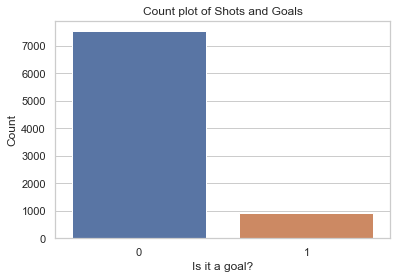

In [82]:
# take a subset for any shots on goal
shots = events[events.eventName == 'Shot']

# make a countplot of goals and misses
sns.countplot(x='goal', data=shots)
plt.title('Count plot of Shots and Goals')
plt.xlabel('Is it a goal?')
plt.ylabel('Count')
plt.show()

As you can see the data is very imbalanced, with much fewer goals than misses. To solve this problem for our preliminary model we will simply undersample the missed shots.

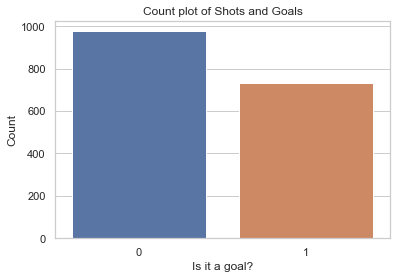

In [83]:
from imblearn.under_sampling import RandomUnderSampler

# split data into x and y values
X = shots[['start_x', 'start_y', 'interval', 'goal_proba', 'save_proba', 'matchPeriod', 'inaccurate']]
y = shots.goal

# split data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train_samp, y_train_samp = RandomUnderSampler(sampling_strategy=0.75).fit_resample(X_train, y_train)

# plot counts to check for balance
sns.countplot(x=y_train_samp)
plt.title('Count plot of Shots and Goals')
plt.xlabel('Is it a goal?')
plt.ylabel('Count')
plt.show()

The above count plot shows that the dataset is now more balanced. However, the downside of undersampling is that we have just thrown away a large portion of our data. This will have a negative impact on the model's predictive power and we will explore other options as we make the model more robust. To try and combat this we will implement synthetic minority oversampling technique (SMOTE) and then undersample so that we can result in a more balanced dataset without losing as much of the majority class.

In [84]:
logreg = LogisticRegression()#solver='lbfgs')
logreg.fit(X_train_samp, y_train_samp)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.78


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [85]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[1137  372]
 [   4  178]]


In [86]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86      1509
           1       0.32      0.98      0.49       182

    accuracy                           0.78      1691
   macro avg       0.66      0.87      0.67      1691
weighted avg       0.92      0.78      0.82      1691



The above model looks decent but shows that there is a problem with precision in the minority class and a lot of misses are mistakenly being classified as goals in order to achieve a high level of goal recall. Going forward we will see if we can balance the precision and recall.

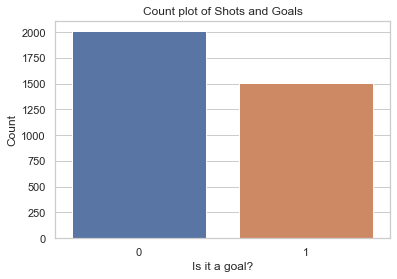

In [87]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# define over/under sample methods and build pipeline
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.75)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# perform over/under sampling
X_train_samp, y_train_samp = pipeline.fit_resample(X, y)


# plot counts to check for balance
sns.countplot(x=y_train_samp)
plt.title('Count plot of Shots and Goals')
plt.xlabel('Is it a goal?')
plt.ylabel('Count')
plt.show()

In [93]:
y_train

430346    0
156926    0
110953    0
99224     0
425987    0
         ..
429686    0
387830    0
403808    0
59246     0
548498    0
Name: goal, Length: 6760, dtype: int64

In [91]:
from sklearn.model_selection import GridSearchCV

max_iter=[100,110,120,130,140]
C = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
param_grid = dict(max_iter=max_iter, C=C)

logreg = LogisticRegression()#solver='lbfgs')

grid = GridSearchCV(estimator=logreg, param_grid=param_grid, cv = 5, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(grid_result.score(X_test, y_test)))

exception calling callback for <Future at 0x1a4166f1d0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/_parallel_backends.py", line 510, in apply_async
    future = self._workers.submit(SafeFunction(func))
 

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

In [57]:
print(metrics.classification_report(y_test, y_pred))

y_pred = grid.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred)
print()
print('Confusion Matrix:')
print(cf_matrix)

              precision    recall  f1-score   support

           0       0.97      0.88      0.92      1509
           1       0.44      0.80      0.57       182

    accuracy                           0.87      1691
   macro avg       0.71      0.84      0.75      1691
weighted avg       0.92      0.87      0.88      1691


Confusion Matrix:
[[1168  341]
 [   7  175]]


The SMOTE sampling combined with grid search cross validation has significantly improved upon the original model showing the precision for the minority class jumping to 0.51 from 0.33. This required a compromise with the recall dropping to 0.70 from 0.99 but we have reduced the type 1 error with only a slight reduction in the true positives.

Logistic: ROC AUC=0.928


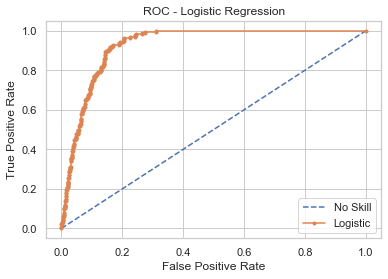

In [49]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

#set model to plot
model = grid

# predict probabilities
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
auc = roc_auc_score(y_test, probs)
# summarize scores
print('Logistic: ROC AUC=%.3f' % (auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
fpr, tpr, _ = roc_curve(y_test, probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.title('ROC - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Logistic: f1=0.501 auc=0.511


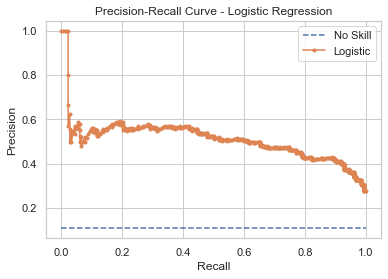

In [50]:
# precision-recall curve and f1
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

probs = grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
y_hat = grid.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, probs)
f1, auc = f1_score(y_test, y_hat), auc(recall, precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (f1, auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.title('Precision-Recall Curve - Logistic Regression')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Next we'll implement a random forest classifier to see if we can improve upon the linear regression model

In [56]:
from sklearn.ensemble import RandomForestClassifier

# split data into x and y values
X = shots[['start_x', 'start_y', 'interval', 'goal_proba', 'save_proba', 'matchPeriod', 'inaccurate']]
y = shots.goal

# split data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

RdmFrst = RandomForestClassifier(max_depth=10, random_state=42, class_weight='balanced')
RdmFrst.fit(X_train, y_train)

y_pred = RdmFrst.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
print()
print('Confusion Matrix:')
print(cf_matrix)

              precision    recall  f1-score   support

           0       0.97      0.88      0.92      1509
           1       0.44      0.80      0.57       182

    accuracy                           0.87      1691
   macro avg       0.71      0.84      0.75      1691
weighted avg       0.92      0.87      0.88      1691


Confusion Matrix:
[[1388  121]
 [  52  130]]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [53]:
cf_matrix = confusion_matrix(y_test, y_pred)
print('Accuracy of random forrest classifier on test set: {:.3f}'.format(RdmFrst.score(X_test, y_test)))
feature_names = X_test.columns.values
predictor_importance = RdmFrst.feature_importances_
print('\nFeature Importances:')
for x in range(0, len(feature_names)):
    print(feature_names[x], '%.4f' % (predictor_importance[x]))

Accuracy of random forrest classifier on test set: 0.869

Feature Importances:
start_x 0.1329
start_y 0.0747
interval 0.0510
goal_proba 0.1299
save_proba 0.0020
matchPeriod 0.0058
inaccurate 0.6038

Confusion Matrix:
[[1387  122]
 [  54  128]]


Using the random forest model we have significantly reduced the number of false positives as compared to linear regression.

In [55]:
from xgboost import XGBClassifier

XGB = XGBClassifier(scale_pos_weight=2)
XGB.fit(X_train, y_train)

y_pred = XGB.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

cf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cf_matrix)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1509
           1       0.52      0.71      0.60       182

    accuracy                           0.90      1691
   macro avg       0.74      0.82      0.77      1691
weighted avg       0.92      0.90      0.90      1691

Confusion Matrix:
[[1388  121]
 [  52  130]]


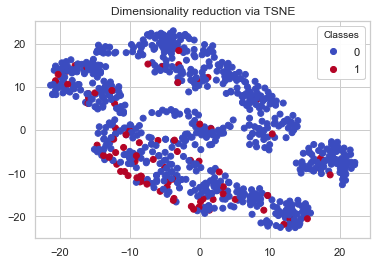

In [20]:
from sklearn.manifold import TSNE

X_sample = X.sample(n=800, random_state=42)
y_sample = y.loc[X_sample.index]

tsne_x = TSNE(n_components=2, perplexity=50, n_iter=30000)
X_embedded = tsne_x.fit_transform(X_sample)

fig, ax = plt.subplots()
scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_sample, cmap='coolwarm')
ax.set_title('Dimensionality reduction via TSNE')
legend = ax.legend(*scatter.legend_elements(), loc="best", title="Classes")
ax.add_artist(legend)
ax.axis('tight')
plt.show()

### Above we can see that after reducing dimensionality there is not clear grouping which may relate to the difficulty we are having it clearly identifying the minority class from the majority class.

In [21]:

param_grid = {"learning_rate"    : [0.03, 0.05, 0.10] ,
              "max_depth"        : [ 2, 5, 8],
              "min_child_weight" : [ 1, 4, 7 ],
              "gamma"            : [ 0.6, 0.8, 1.0 ],
              "colsample_bytree" : [ 0.8, 0.9, 1]}

XGB = XGBClassifier(scale_pos_weight=2)

XGB_grid = GridSearchCV(estimator=XGB, param_grid=param_grid, cv = 5, n_jobs=-1, scoring='f1')
XGB_grid_result = XGB_grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (XGB_grid_result.best_score_, XGB_grid_result.best_params_))
print('F1 score of XGBoost classifier on test set: {:.2f}'.format(XGB_grid_result.score(X_test, y_test)))



Best: 0.593891 using {'colsample_bytree': 1, 'gamma': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1}
Accuracy of XGBoost classifier on test set: 0.59


In [94]:
XGB = XGBClassifier(scale_pos_weight=2, colsample_bytree=1, gamma=0.8, learning_rate=0.05, max_depth=5, min_child_weight=1)

#Best: 0.568402 using {'colsample_bytree': 0.9, 'gamma': 0.4, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 7}
#XGB = XGBClassifier(scale_pos_weight=2, colsample_bytree=0.5, gamma=0.2, learning_rate=0.05, max_depth=15, min_child_weight=1)
#XGB = XGBClassifier(scale_pos_weight=2, colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, max_depth=12, min_child_weight=1)
XGB.fit(X_train, y_train)
y_pred = XGB_grid_result.best_estimator_.predict(X_test)

print(XGB.feature_importances_)

print(metrics.classification_report(y_test, y_pred))

cf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cf_matrix)

[0.05617302 0.03246143 0.01402839 0.05117793 0.         0.0152725
 0.8308867 ]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1509
           1       0.51      0.70      0.59       182

    accuracy                           0.90      1691
   macro avg       0.74      0.81      0.77      1691
weighted avg       0.91      0.90      0.90      1691

Confusion Matrix:
[[1387  122]
 [  54  128]]


In [95]:
feature_names = X_test.columns.values
predictor_importance = XGB.feature_importances_
print('\nFeature Importances:')
for x in range(0, len(feature_names)):
    print(feature_names[x], '%.4f' % (predictor_importance[x]))


Feature Importances:
start_x 0.0562
start_y 0.0325
interval 0.0140
goal_proba 0.0512
save_proba 0.0000
matchPeriod 0.0153
inaccurate 0.8309


XGB: ROC AUC=0.934


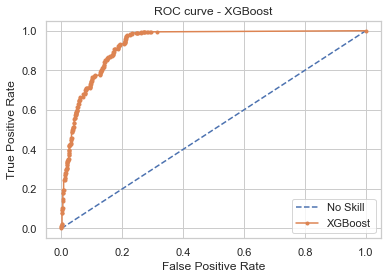

In [48]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

#set model to plot
model = XGB

# predict probabilities
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
auc = roc_auc_score(y_test, probs)
# summarize scores
print('XGB: ROC AUC=%.3f' % (auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
fpr, tpr, _ = roc_curve(y_test, probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='XGBoost')
# axis labels
plt.title('ROC curve - XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

XGBoost: f1=0.593 auc=0.599


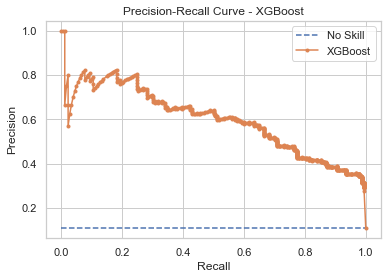

In [47]:
# precision-recall curve and f1
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

probs = XGB.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
y_hat = XGB.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, probs)
f1, auc = f1_score(y_test, y_hat), auc(recall, precision)
# summarize scores
print('XGBoost: f1=%.3f auc=%.3f' % (f1, auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='XGBoost')
# axis labels
pyplot.title('Precision-Recall Curve - XGBoost')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Overall we see that while there is still room for improvement the tuned XGBoost model clearly outperforms a no-skill scenario. XGBoost has further increased the precision for the minority class but has cost some in recall so the preferred model will depend on the ultimate application of the model.